<a href="https://colab.research.google.com/github/mayalenE/sketch-transformer/blob/main/transformer_sketch_generation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Let's implement it! 💻

### Imports and Utils

In [41]:
!pip install svgwrite

Defaulting to user installation because normal site-packages is not writeable


In [42]:
import numpy as np
import torch
import torch.nn as nn
from torch.nn import functional as F
from torch.distributions import MultivariateNormal, OneHotCategorical, Categorical
import requests
import io
import svgwrite
from IPython.display import Image, SVG, display, HTML


In [43]:
torch.manual_seed(1337)

In [44]:
# Hyper-parameters
data_classes = ["cat"]
batch_size = 512 # how many independent sequences will we process in parallel?
# block_size = None # what is the maximum context length for predictions? here we take block_size = max number of strokes of our database
training_iters = 24000
eval_interval = training_iters // 20
learning_rate = 1e-4
device = 'cuda' if torch.cuda.is_available() else 'cpu'
eval_iters = 10
embd = 384
embd_ffn = 4 * embd # 4times as in "attention is all you need paper"
num_heads = 6 #every head is embd/num_head dimensional
n_layers = 6
dropout = 0.2 # 20% of operations are randomly masked at each forward/backward pass
n_components = 20 # number of gaussians in the MDN output layer

In [45]:
# helper function for draw_strokes
def get_bounds(data, factor):
  min_x = 0
  max_x = 0
  min_y = 0
  max_y = 0

  abs_x = 0
  abs_y = 0
  for i in range(len(data)):
    x = float(data[i,0])/factor
    y = float(data[i,1])/factor
    abs_x += x
    abs_y += y
    min_x = min(min_x, abs_x)
    min_y = min(min_y, abs_y)
    max_x = max(max_x, abs_x)
    max_y = max(max_y, abs_y)

  return (min_x, max_x, min_y, max_y)

def create_path(data, factor, abs_x, abs_y, lift_pen=1):
  command = "m"
  p = "M%s,%s " % (abs_x, abs_y)
  for i in range(len(data)):
    if (lift_pen == 1):
      command = "m"
    elif (command != "l"):
      command = "l"
    else:
      command = ""
    x = float(data[i,0])/factor
    abs_x += x
    y = float(data[i,1])/factor
    abs_y += y
    lift_pen = data[i, 2]
    p += command+str(x)+","+str(y)+" "
  return p, abs_x, abs_y

# little function that displays vector images
def draw_strokes(data, factor=0.2, svg_filename='sample.svg', the_color="black", stroke_width=1):
  min_x, max_x, min_y, max_y = get_bounds(data, factor)
  dims = (50 + max_x - min_x, 50 + max_y - min_y)
  dwg = svgwrite.Drawing(svg_filename, size=dims)
  dwg.add(dwg.rect(insert=(0, 0), size=dims,fill='white'))
  abs_x = 25 - min_x
  abs_y = 25 - min_y
  p, _, _ = create_path(data, factor, abs_x, abs_y)
  dwg.add(dwg.path(p).stroke(the_color,stroke_width).fill("none"))
  dwg.save()
  svg_str = dwg.tostring()
  return svg_str

def draw_two_strokes(data1, data2, color1="black", color2="brown", factor=0.2, svg_filename="sample.svg", stroke_width=1):
  min_x, max_x, min_y, max_y = get_bounds(torch.concatenate([data1, data2]), factor)
  dims = (50 + max_x - min_x, 50 + max_y - min_y)
  dwg = svgwrite.Drawing(svg_filename, size=dims)
  dwg.add(dwg.rect(insert=(0, 0), size=dims,fill='white'))
  abs_x = 25 - min_x
  abs_y = 25 - min_y
  p1, abs_x, abs_y = create_path(data1, factor, abs_x, abs_y)
  dwg.add(dwg.path(p1).stroke(color1, stroke_width).fill("none"))
  p2, _, _ = create_path(data2, factor, abs_x, abs_y, lift_pen=0)
  dwg.add(dwg.path(p2).stroke(color2, stroke_width).fill("none"))
  dwg.save()
  svg_str = dwg.tostring()
  return svg_str

### Prepare the Dataset

In [46]:
train_set, valid_set, test_set = [], [], []
for data_class in data_classes:
  data_url = f"https://storage.googleapis.com/quickdraw_dataset/sketchrnn/{data_class}.npz"
  response = requests.get(data_url)
  response.raise_for_status()
  load_data = np.load(io.BytesIO(response.content), allow_pickle=True, encoding='latin1')
  train_set += load_data['train'].tolist()
  valid_set += load_data['valid'].tolist()
  test_set += load_data['test'].tolist()

print(len(train_set))
print(len(valid_set))
print(len(test_set))

70000
2500
2500


In [47]:
# get max len
max_len = 0
for x in train_set:
    max_len = max(max_len,len(x))
print(max_len)
block_size = max_len
assert block_size <= 250

129


In [48]:
max_w = 0
max_h = 0
x_mean = 0.
y_mean = 0.
x_std = 1.
y_std = 1.
N = 0
for x in train_set:
    min_x, max_x, min_y, max_y = get_bounds(x, factor=1)
    max_w = max(max_w, max_x-min_x)
    max_h = max(max_h, max_y-min_y)
    x_std += ((x[:,0] - x_mean)**2).sum()
    y_std += ((x[:,1] - y_mean)**2).sum()
    N += len(x)
x_std = np.sqrt(x_std/N)
y_std = np.sqrt(y_std/N)
print(max_w, max_h, x_std, y_std)

2263.0 1116.0 51.54030056217729 32.8188575795014


In [49]:
# data loading
def get_batch(split):
    # generate a small batch of data of inputs x and targets y
    if split == "train":
        data = train_set
    elif split == "valid":
        data = valid_set
    else:
        data = test_set
    ix = torch.randint(len(data), (batch_size,))
    xs = []
    ys = []
    lengths = []
    for i in ix:
        # convert in stroke-5 with normalizedx-y values to be roughly N(0,I)
        x, y, p = torch.tensor(data[i]).T
        x = torch.maximum(torch.minimum(x, torch.tensor([1000])), torch.tensor([-1000]))
        x = (x - x_mean) / x_std
        y = torch.maximum(torch.minimum(y, torch.tensor([1000])), torch.tensor([-1000]))
        y = (y - y_mean) / y_std
        p[-1] = 2.
        d = torch.stack([x, y, p], -1)
        # pad with empty values till block size
        xs.append(torch.concatenate([d, torch.tensor([0., 0., 2.]).repeat((block_size-len(d), 1))]))
        ys.append(torch.concatenate([d[1:], torch.tensor([0., 0., 2.]).repeat((block_size+1-len(d), 1))]))
        lengths.append(len(data[i]))
    xs, ys, lengths = torch.stack(xs), torch.stack(ys), torch.tensor(lengths)
    mask = torch.arange(block_size).expand((batch_size, block_size)) <=  lengths.unsqueeze(1).expand((batch_size, block_size))
    xs, ys, mask = xs.to(device), ys.to(device), mask.to(device)
    return xs, ys, mask

In [50]:
# draw random examples from the train set
xs, ys, mask = get_batch("train")
print(xs.shape)

n_samples = 10
svg_samples = [draw_strokes(xs[i], factor=0.1) for i in range(n_samples)]
no_wrap_div = '<div style="white-space: nowrap">'+'{}'*n_samples+'</div>'
display(HTML(no_wrap_div.format(*svg_samples)))


torch.Size([512, 129, 3])


### Model: Autoregressive Transformer (Decoder) + MDN

In [51]:
class MDN(nn.Module):
    """
    Mixture density network compatible with full covariance.
    Adapted from https://github.com/haimengzhao/full-cov-mdn

    [ Bishop, 1994 ]

    Parameters
    ----------
    dim_in: int; dimensionality of the covariates
    dim_out: int; dimensionality of the response variable
    n_components: int; number of components in the mixture model
    full_cov: bool; whether to use full or diagonal covariance matrix
    """
    def __init__(self, dim_in, dim_out, n_components, full_cov=True):
        super().__init__()
        self.pi_net = OneHotCategoricalNetwork(dim_in, n_components)
        self.normal_net = NormalNetwork(dim_in, dim_out, n_components, full_cov)

    def forward(self, x, tau=1.):
        return self.pi_net(x, tau), self.normal_net(x, tau)


class NormalNetwork(nn.Module):
    def __init__(self, in_dim, out_dim, n_components, full_cov=True):
        super().__init__()
        self.n_components = n_components
        self.out_dim = out_dim
        self.full_cov = full_cov
        self.tril_indices = torch.tril_indices(row=out_dim, col=out_dim, offset=0)
        self.mean_net = nn.Linear(in_dim, out_dim * n_components)
        if full_cov:
            # Cholesky decomposition of the covariance matrix
            self.tril_net = nn.Linear(in_dim, int(out_dim * (out_dim + 1) / 2 * n_components))
        else:
            self.tril_net = nn.Linear(in_dim, out_dim * n_components)

    def forward(self, x, tau=1.):
        mean = self.mean_net(x).reshape(x.shape[0], x.shape[1], self.n_components, self.out_dim) # B, T, M, d
        if self.full_cov:
            tril_values = self.tril_net(x).reshape(x.shape[0], x.shape[1], self.n_components, -1) # B, T, M, (d**2+d)/2
            tril = torch.zeros(mean.shape[0], mean.shape[1], mean.shape[2], mean.shape[3], mean.shape[3]).to(x.device) # B, T, M, d, d
            tril[:, :, :, self.tril_indices[0], self.tril_indices[1]] = tril_values
            # use diag = exp(diag) to ensure stric positivity of diagonal elements
            tril.diagonal(dim1=-2, dim2=-1)[:] = tril.diagonal(dim1=-2, dim2=-1).exp()
        else:
            tril = self.tril_net(x).reshape(x.shape[0], x.shape[1], self.n_components, -1)
            tril = torch.diag_embed(tril.exp())
        tril *= tau
        return MultivariateNormal(mean, scale_tril=tril)

class OneHotCategoricalNetwork(nn.Module):

    def __init__(self, in_dim, out_dim):
        super().__init__()
        self.network = nn.Linear(in_dim, out_dim)

    def forward(self, x, tau=1.):
        logits = self.network(x) / tau
        return OneHotCategorical(logits=logits)

class CategoricalNetwork(nn.Module):

    def __init__(self, in_dim, out_dim):
        super().__init__()
        self.network = nn.Linear(in_dim, out_dim)

    def forward(self, x, tau=1.):
        logits = self.network(x) / tau
        return Categorical(logits=logits)

In [52]:
# Attention Head
class Head(nn.Module):

    def __init__(self, head_size):
        super().__init__()
        self.query = nn.Linear(embd, head_size, bias=False)
        self.key = nn.Linear(embd, head_size, bias=False)
        self.value = nn.Linear(embd, head_size, bias=False)
        self.register_buffer("tril", torch.tril(torch.ones(block_size, block_size)))

    def forward(self, x):
        B, T, C = x.shape

        q = self.query(x) # B, T, C
        k = self.key(x) # B, T, C

        # compute an attention score ("affinities")
        wei = q@k.transpose(-2, -1) * C **(-0.5)
        wei = wei.masked_fill(self.tril[:T, :T] == 0, float("-inf")) # "decoder" block because of triangular masking (autoregressive setting)
        wei = F.softmax(wei, dim=-1)

        # perform the weighted aggregation of the values
        v = self.value(x)  # B, T, C
        out = wei @ v # B, T, C

        return out

class MultiHead(nn.Module):

    def __init__(self, num_heads, head_size):
        super().__init__()
        self.heads = nn.ModuleList([Head(head_size) for _ in range(num_heads)])
        self.proj = nn.Linear(embd, embd) #projection layer going back into the residual pathway

    def forward(self, x):
        out = torch.cat([h(x) for h in self.heads], dim=-1)
        out = self.proj(out)
        return out

class FeedForward(nn.Module):

    def __init__(self, embd):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(embd, embd_ffn),
            nn.ReLU(),
            nn.Linear(embd_ffn, embd), # projection layer going back into the residual pathway
            nn.Dropout(dropout)
        )

    def forward(self, x):
        return self.net(x)


class Block(nn.Module):
    """ Transformer Block: communication/sensing followed by computation/update"""

    def __init__(self, embd, num_heads):
        super().__init__()
        self.sa_heads = MultiHead(num_heads, embd//num_heads)
        self.ffwd = FeedForward(embd)
        self.ln1 = nn.LayerNorm(embd) #should be equivalent to LayerNorm1D
        self.ln2 = nn.LayerNorm(embd)

    def forward(self, x):
        # x = self.sa_heads(x) # apply one head of self-attention (B, T, C) <=> "comunication" or "sense"
        # x = self.ffwd(x) # (B, T, C) => this is one a per-token level <=> "update"
        x = x + self.sa_heads(self.ln1(x)) # residual connection <=> "highway" of information and residual paths
        x = x + self.ffwd(self.ln2(x)) # residual connection

        return x

class TransformerModel(nn.Module):

    def __init__(self):
        super().__init__()
        # each token directly reads off the logits for the next token from a lookup table
        self.stroke_embedding_proj = nn.Linear(2, embd, bias=False)
        self.pen_embedding_table = nn.Embedding(3, embd)
        self.position_embedding_table = nn.Embedding(block_size, embd)
        self.blocks = nn.Sequential(*[Block(embd, num_heads) for _ in range(n_layers)])
        self.ln_f = nn.LayerNorm(embd)
        self.mdn_head = MDN(embd, 2, n_components)
        self.pen_head = CategoricalNetwork(embd, 3)

    def forward(self, x, tau=1.):
        B, T, C = x.shape
        # assert C == 3

        # idx and targets are both (B,T) tensor of integers
        stroke_emb = self.stroke_embedding_proj(x[:, :, :2]) # (B,T,2) @ (2, embd) = (B, T, embd)
        pen_emb = self.pen_embedding_table(x[:, :, 2].long()) # (B, T, embd)
        pos_emb = self.position_embedding_table(torch.arange(T, device=device)) #(T, embd)
        x = stroke_emb + pen_emb + pos_emb # (B, T, embd)

        # forward through attention heads
        x = self.blocks(x)  # (B, T, C)
        x = self.ln_f(x)

        # forward though mdn and head
        pi_net, normal_net = self.mdn_head(x, tau=tau)
        q_net = self.pen_head(x, tau=tau)

        return pi_net, normal_net, q_net


    def loss(self, x, targets, mask):
        pi, normal, q = self.forward(x)
        ys = targets[:, :, :2]
        loglik = normal.log_prob(ys.unsqueeze(-2).expand_as(normal.loc))
        Ls = -torch.logsumexp(torch.log(pi.probs) + loglik, dim=-1)
        Ls *= mask


        yp = targets[:, :, 2]
        Lp = -q.log_prob(yp)
        return Ls + Lp


    def sample(self, x, tau=1.):
        pi, normal, q = self.forward(x, tau)
        s_samples = torch.sum(pi.sample().unsqueeze(-1) * normal.sample(), dim=-2)
        p_samples = q.sample()
        return torch.cat([s_samples, p_samples.unsqueeze(-1)], dim=-1)


    @torch.no_grad()
    def generate(self, x, max_new_tokens, tau=1., break_eos=True):

        # x is (1, T, 3)
        for _ in range(max_new_tokens):

            # get the predictions
            samples_next = self.sample(x, tau=tau)[:, -1, :].unsqueeze(1)

            # append sampled stroke + pen index to the running sequence
            x = torch.cat([x, samples_next], dim=1)

            # break if end of sketch
            if break_eos:
                if samples_next[0,0,2] == 2:
                    return x

        return x

In [53]:
model = TransformerModel()
model = model.to(device)
print(f"Model has {sum([p.nelement() for p in model.parameters()])} parameters")

Model has 10739451 parameters


In [54]:
X, Y, mask = get_batch("train")
Y_pred = model.sample(X)
print(X.shape, Y.shape, Y_pred.shape)

torch.Size([512, 129, 3]) torch.Size([512, 129, 3]) torch.Size([512, 129, 3])


### Training


In [55]:
@torch.no_grad()
def estimate_loss():
    out = {}
    for split in ['train', 'val']:
        losses = torch.zeros(eval_iters)
        for k in range(eval_iters):
            X, Y, mask = get_batch(split)
            loss = model.loss(X, Y, mask)
            losses[k] = loss.mean()
        out[split] = losses.mean()
    return out

In [56]:
# create a PyTorch optimizer
optimizer = torch.optim.AdamW(model.parameters(), lr=learning_rate)
#lr_scheduler = torch.optim.lr_scheduler.LinearLR(optimizer, start_factor=1.0, end_factor=0.01, total_iters=training_iters)

for iter in range(training_iters):

  #every once in a while evaluate the loss on train and val sets
  if iter % eval_interval == 0:
      model.eval()

      # evaluate loss
      losses = estimate_loss()
      print(f'step {iter}: lr {optimizer.param_groups[0]["lr"]:.6f}, train loss {losses["train"]:.4f}, val loss {losses["val"]:.4f}')

      # display random samples at current stage of training
      n_samples = 10
      svg_samples = [draw_strokes(model.generate(torch.zeros(1, 1, 3).to(device), max_new_tokens=block_size-1, break_eos=True, tau=.4)[0], factor=0.1) for _ in range(n_samples)]
      no_wrap_div = '<div style="white-space: nowrap">'+'{}'*n_samples+'</div>'
      display(HTML(no_wrap_div.format(*svg_samples)))

      model.train()

  # sample a batch of data
  xb, yb, mask = get_batch('train')

  # evaluate the loss
  loss = model.loss(xb, yb, mask).mean()

  # backward pass
  optimizer.zero_grad(set_to_none=True)
  loss.backward()
  optimizer.step()
  #lr_scheduler.step()

step 0: lr 0.000100, train loss 2.5449, val loss 2.5287


OutOfMemoryError: CUDA out of memory. Tried to allocate 388.00 MiB. GPU 0 has a total capacity of 15.62 GiB of which 135.81 MiB is free. Process 330123 has 5.64 GiB memory in use. Including non-PyTorch memory, this process has 9.21 GiB memory in use. Of the allocated memory 8.32 GiB is allocated by PyTorch, and 714.41 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)

[Optional] The below code saves the trained weights to your local machine, which can be useful if you do not want to re-train the model each time. Note that we already provide trained weights for the `cat` dataclass on the [github repository](https://github.com/mayalenE/sketch-transformer).

### Evaluation

In [18]:
model.eval()

TransformerModel(
  (stroke_embedding_proj): Linear(in_features=2, out_features=384, bias=False)
  (pen_embedding_table): Embedding(3, 384)
  (position_embedding_table): Embedding(129, 384)
  (blocks): Sequential(
    (0): Block(
      (sa_heads): MultiHead(
        (heads): ModuleList(
          (0-5): 6 x Head(
            (query): Linear(in_features=384, out_features=64, bias=False)
            (key): Linear(in_features=384, out_features=64, bias=False)
            (value): Linear(in_features=384, out_features=64, bias=False)
          )
        )
        (proj): Linear(in_features=384, out_features=384, bias=True)
      )
      (ffwd): FeedForward(
        (net): Sequential(
          (0): Linear(in_features=384, out_features=1536, bias=True)
          (1): ReLU()
          (2): Linear(in_features=1536, out_features=384, bias=True)
          (3): Dropout(p=0.2, inplace=False)
        )
      )
      (ln1): LayerNorm((384,), eps=1e-05, elementwise_affine=True)
      (ln2): LayerNorm

In [19]:
# Evaluate Reconstruction Loss on the full test set
@torch.no_grad()
def test_loss():
    out = {}
    model.eval()

    # convert in stroke-5 with normalizedx-y values to be roughly N(0,I)
    xs, ys, lengths = [], [], []
    for i in range(len(test_set)):
      x, y, p = torch.tensor(test_set[i]).T
      x = (x - x_mean) / x_std
      y = (y - y_mean) / y_std
      p[-1] = 2.
      d = torch.stack([x, y, p], -1)
      # pad with empty values till block size
      xs.append(torch.concatenate([d, torch.tensor([0., 0., 2.]).repeat((block_size-len(d), 1))]))
      ys.append(torch.concatenate([d[1:], torch.tensor([0., 0., 2.]).repeat((block_size+1-len(d), 1))]))
      lengths.append(len(test_set[i]))
    xs, ys, lengths = torch.stack(xs), torch.stack(ys), torch.tensor(lengths)
    mask = torch.arange(block_size).expand((len(test_set), block_size)) <=  lengths.unsqueeze(1).expand((len(test_set), block_size))
    xs, ys, mask = xs.to(device), ys.to(device), mask.to(device)
    loss = model.loss(xs, ys, mask)
    return loss


print(f"LR: {test_loss().mean()}")

LR: 0.18573611974716187


👉 The loss over the whole test set is $L_R \approx 0.21$.

In [20]:
# Complete Sketch from the test set with the trained model
X, Y, _ = get_batch("test")
n_samples = 5
n_per_sample = 10
t_init = 5
for i in range(n_samples):
  svg_samples = [draw_strokes(model.generate(X[i, :t_init].unsqueeze(0).to(device), max_new_tokens=block_size-t_init, break_eos=True, tau=.4)[0], factor=0.1) for _ in range(n_per_sample)]
  no_wrap_div = '<div style="white-space: nowrap">'+'{}'*n_per_sample+'</div>'
  display(HTML(no_wrap_div.format(*svg_samples)))

In [ ]:
# Get human's strokes
size = 400
input_strokes = draw(w=size, h=size)


# Process strokes
x_start = torch.tensor(input_strokes).float()
x_start = (x_start - size/2) / torch.tensor([x_std, y_std], dtype=torch.float32)
x_start = torch.concatenate([x_start[0].unsqueeze(0), x_start[1:] - x_start[:-1]])
x_start = torch.concatenate([x_start, torch.zeros((len(x_start), 1))], dim=1).unsqueeze(0).to(device)
print(x_start.shape)


# Feed to model
n_samples = 10
xs = [model.generate(x_start, max_new_tokens=block_size-x_start.shape[1], break_eos=True, tau=.4) for _ in range(n_samples)]

# Display completion
svg_samples = [draw_two_strokes(x_start[0], x[0, x_start.shape[1]:], factor=0.1) for x in xs]
no_wrap_div = '<div style="white-space: nowrap">'+'{}'*n_samples+'</div>'
display(HTML(no_wrap_div.format(*svg_samples)))


In [1]:
import numpy as np
import torch
import torch.nn as nn
from torch.nn import functional as F
from torch.distributions import MultivariateNormal, OneHotCategorical, Categorical
import requests
import io
import svgwrite
from IPython.display import Image, SVG, display, HTML
import os
import time
from tqdm import tqdm

torch.manual_seed(1337)

# Hyper-parameters
data_classes = ["apple","cat", "airplane", "apple", "bicycle", "fish", "pizza", "umbrella", "t-shirt", "tree", "car"]
batch_size = 256
training_iters = 40000
eval_interval = training_iters // 20
learning_rate = 1e-4
device = 'cuda' if torch.cuda.is_available() else 'cpu'
eval_iters = 10
embd = 384
embd_ffn = 4 * embd
num_heads = 6
n_layers = 6
dropout = 0.2
n_components = 20

# Early stopping parameters
early_stopping_patience = 5  # Number of evaluations without improvement
early_stopping_min_delta = 0.001  # Minimum change to qualify as improvement
early_stopping_verbose = True

print(f"Using device: {device}")

# Helper functions for drawing strokes
def get_bounds(data, factor):
    min_x = 0
    max_x = 0
    min_y = 0
    max_y = 0
    abs_x = 0
    abs_y = 0
    for i in range(len(data)):
        x = float(data[i, 0]) / factor
        y = float(data[i, 1]) / factor
        abs_x += x
        abs_y += y
        min_x = min(min_x, abs_x)
        min_y = min(min_y, abs_y)
        max_x = max(max_x, abs_x)
        max_y = max(max_y, abs_y)
    return (min_x, max_x, min_y, max_y)

def create_path(data, factor, abs_x, abs_y, lift_pen=1):
    command = "m"
    p = "M%s,%s " % (abs_x, abs_y)
    for i in range(len(data)):
        if (lift_pen == 1):
            command = "m"
        elif (command != "l"):
            command = "l"
        else:
            command = ""
        x = float(data[i, 0]) / factor
        abs_x += x
        y = float(data[i, 1]) / factor
        abs_y += y
        lift_pen = data[i, 2]
        p += command + str(x) + "," + str(y) + " "
    return p, abs_x, abs_y

def draw_strokes(data, factor=0.2, svg_filename='sample.svg', the_color="black", stroke_width=1):
    if isinstance(data, torch.Tensor):
        data = data.cpu().numpy()
    min_x, max_x, min_y, max_y = get_bounds(data, factor)
    dims = (50 + max_x - min_x, 50 + max_y - min_y)
    dwg = svgwrite.Drawing(svg_filename, size=dims)
    dwg.add(dwg.rect(insert=(0, 0), size=dims, fill='white'))
    abs_x = 25 - min_x
    abs_y = 25 - min_y
    p, abs_x, abs_y = create_path(data, factor, abs_x, abs_y)
    dwg.add(dwg.path(p).stroke(the_color, stroke_width).fill("none"))
    dwg.save()
    svg_str = dwg.tostring()
    return svg_str

# Create output directory
os.makedirs("sketch_samples", exist_ok=True)
print("Created output directory: sketch_samples")

# Load and preprocess data
print("Loading data for classes:", data_classes)
train_data = []
valid_data = []
test_data = []
train_class_indices = []

for class_idx, data_class in enumerate(data_classes):
    try:
        data_url = f"https://storage.googleapis.com/quickdraw_dataset/sketchrnn/{data_class}.npz"
        print(f"Downloading {data_class} data from {data_url}")
        response = requests.get(data_url)
        response.raise_for_status()
        load_data = np.load(io.BytesIO(response.content), allow_pickle=True, encoding='latin1')
        class_train_data = load_data['train'].tolist()
        class_valid_data = load_data['valid'].tolist()
        class_test_data = load_data['test'].tolist()
        train_data.extend(class_train_data)
        valid_data.extend(class_valid_data)
        test_data.extend(class_test_data)
        train_class_indices.extend([class_idx] * len(class_train_data))
        print(f"Loaded {len(class_train_data)} training, {len(class_valid_data)} validation, {len(class_test_data)} test examples for class {data_class}")
    except Exception as e:
        print(f"Error loading {data_class}: {e}")
        print(f"Continuing without class {data_class}")

print(f"Total training examples: {len(train_data)}")
print(f"Total validation examples: {len(valid_data)}")
print(f"Total test examples: {len(test_data)}")
print(f"Length of train_class_indices: {len(train_class_indices)}")

assert len(train_data) == len(train_class_indices), "Mismatch between training data and class indices!"

# Determine maximum sequence length
max_len = 0
for x in train_data[:1000]:
    max_len = max(max_len, len(x))
block_size = min(max_len, 200)
print(f"Maximum sequence length: {block_size}")

# Calculate data statistics for normalization
print("Calculating data statistics...")
max_w = 0
max_h = 0
x_mean = 0.
y_mean = 0.
x_std = 1.
y_std = 1.
N = 0
sample_count = min(10000, len(train_data))
for x in tqdm(train_data[:sample_count], desc="Processing train data for statistics"):
    if isinstance(x, list):
        x = np.array(x)
    if len(x) == 0:
        continue
    try:
        min_x, max_x, min_y, max_y = get_bounds(x, factor=1)
        max_w = max(max_w, max_x - min_x)
        max_h = max(max_h, max_y - min_y)
        x_std += ((x[:, 0] - x_mean) ** 2).sum()
        y_std += ((x[:, 1] - y_mean) ** 2).sum()
        N += len(x)
    except Exception as e:
        print(f"Error processing sample: {e}")
        continue
x_std = np.sqrt(x_std / max(N, 1))
y_std = np.sqrt(y_std / max(N, 1))
print(f"Data statistics: Width={max_w}, Height={max_h}, X_std={x_std}, Y_std={y_std}")

# Data loading function with fixed sequence lengths
def get_batch(split, debug=False):
    if split == "train":
        data = train_data
        class_data = train_class_indices
    elif split == "valid":
        data = valid_data
        class_data = [0] * len(valid_data)
    else:
        data = test_data
        class_data = [0] * len(test_data)

    ix = torch.randint(len(data), (batch_size,))
    xs = []
    ys = []
    lengths = []
    classes = []

    for i in range(batch_size):
        idx = ix[i].item()
        if idx >= len(data):
            if debug:
                print(f"Warning: Index {idx} out of range for {split} data with size {len(data)}")
            idx = 0
        try:
            sketch = data[idx]
            if isinstance(sketch, list):
                sketch = np.array(sketch)
            if len(sketch) == 0:
                sketch = np.zeros((1, 3))
                sketch[0, 2] = 2
            x_vals, y_vals, p = torch.tensor(sketch).T
            x_vals = torch.clamp(x_vals, -1000, 1000)
            x_vals = (x_vals - x_mean) / x_std
            y_vals = torch.clamp(y_vals, -1000, 1000)
            y_vals = (y_vals - y_mean) / y_std
            p[-1] = 2.0
            d = torch.stack([x_vals, y_vals, p], -1)
            seq_len = min(len(d), block_size)
            d = d[:seq_len]
            
            # Ensure we have same length for inputs and targets
            padded_input = torch.zeros(block_size, 3)
            padded_input[:seq_len] = d
            padded_input[seq_len:, 2] = 2.0
            
            # Create target sequence (for autoregressive model)
            padded_target = torch.zeros(block_size, 3)
            padded_target[:seq_len-1] = d[1:seq_len]  # Shift by 1
            padded_target[seq_len-1:, 2] = 2.0
            
            xs.append(padded_input)
            ys.append(padded_target)
            lengths.append(seq_len)
            
            if split == "train":
                if idx < len(class_data):
                    classes.append(class_data[idx])
                else:
                    if debug:
                        print(f"Warning: Class index {idx} out of range!")
                    classes.append(0)
            else:
                classes.append(0)
        except Exception as e:
            if debug:
                print(f"Error processing sample {idx}: {e}")
            dummy = torch.zeros(block_size, 3)
            dummy[:, 2] = 2.0
            xs.append(dummy)
            ys.append(dummy)
            lengths.append(1)
            classes.append(0)

    xs = torch.stack(xs)
    ys = torch.stack(ys)
    lengths = torch.tensor(lengths)
    classes = torch.tensor(classes, dtype=torch.long)
    
    mask = torch.arange(block_size).expand(batch_size, block_size) < lengths.unsqueeze(1)
    
    xs = xs.to(device)
    ys = ys.to(device)
    mask = mask.to(device)
    classes = classes.to(device)
    
    if debug:
        print(f"Batch shapes - xs: {xs.shape}, ys: {ys.shape}, mask: {mask.shape}, classes: {classes.shape}")
        print(f"Sample lengths: min={lengths.min().item()}, max={lengths.max().item()}, mean={lengths.float().mean().item():.1f}")
    
    return xs, ys, mask, classes

# Mixture Density Network components
class MDN(nn.Module):
    def __init__(self, dim_in, dim_out, n_components, full_cov=True):
        super().__init__()
        self.pi_net = OneHotCategoricalNetwork(dim_in, n_components)
        self.normal_net = NormalNetwork(dim_in, dim_out, n_components, full_cov)

    def forward(self, x, tau=1.):
        return self.pi_net(x, tau), self.normal_net(x, tau)

class NormalNetwork(nn.Module):
    def __init__(self, in_dim, out_dim, n_components, full_cov=True):
        super().__init__()
        self.n_components = n_components
        self.out_dim = out_dim
        self.full_cov = full_cov
        self.tril_indices = torch.tril_indices(row=out_dim, col=out_dim, offset=0)
        self.mean_net = nn.Linear(in_dim, out_dim * n_components)
        if full_cov:
            self.tril_net = nn.Linear(in_dim, int(out_dim * (out_dim + 1) / 2 * n_components))
        else:
            self.tril_net = nn.Linear(in_dim, out_dim * n_components)

    def forward(self, x, tau=1.):
        mean = self.mean_net(x).reshape(x.shape[0], x.shape[1], self.n_components, self.out_dim)
        if self.full_cov:
            tril_values = self.tril_net(x).reshape(x.shape[0], x.shape[1], self.n_components, -1)
            tril = torch.zeros(mean.shape[0], mean.shape[1], mean.shape[2], mean.shape[3], mean.shape[3], device=x.device)
            tril[:, :, :, self.tril_indices[0], self.tril_indices[1]] = tril_values
            tril.diagonal(dim1=-2, dim2=-1)[:] = tril.diagonal(dim1=-2, dim2=-1).exp()
        else:
            tril = self.tril_net(x).reshape(x.shape[0], x.shape[1], self.n_components, -1)
            tril = torch.diag_embed(tril.exp())
        tril *= tau
        return MultivariateNormal(mean, scale_tril=tril)

class OneHotCategoricalNetwork(nn.Module):
    def __init__(self, in_dim, out_dim):
        super().__init__()
        self.network = nn.Linear(in_dim, out_dim)

    def forward(self, x, tau=1.):
        logits = self.network(x) / tau
        return OneHotCategorical(logits=logits)

class CategoricalNetwork(nn.Module):
    def __init__(self, in_dim, out_dim):
        super().__init__()
        self.network = nn.Linear(in_dim, out_dim)

    def forward(self, x, tau=1.):
        logits = self.network(x) / tau
        return Categorical(logits=logits)

# Transformer components
class Head(nn.Module):
    def __init__(self, head_size):
        super().__init__()
        self.query = nn.Linear(embd, head_size, bias=False)
        self.key = nn.Linear(embd, head_size, bias=False)
        self.value = nn.Linear(embd, head_size, bias=False)
        self.register_buffer("tril", torch.tril(torch.ones(block_size, block_size)))

    def forward(self, x):
        B, T, C = x.shape
        q = self.query(x)
        k = self.key(x)
        wei = q @ k.transpose(-2, -1) * C ** (-0.5)
        wei = wei.masked_fill(self.tril[:T, :T] == 0, float("-inf"))
        wei = F.softmax(wei, dim=-1)
        v = self.value(x)
        out = wei @ v
        return out

class MultiHead(nn.Module):
    def __init__(self, num_heads, head_size):
        super().__init__()
        self.heads = nn.ModuleList([Head(head_size) for _ in range(num_heads)])
        self.proj = nn.Linear(embd, embd)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x):
        out = torch.cat([h(x) for h in self.heads], dim=-1)
        out = self.dropout(self.proj(out))
        return out

class FeedForward(nn.Module):
    def __init__(self, embd):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(embd, embd_ffn),
            nn.ReLU(),
            nn.Linear(embd_ffn, embd),
            nn.Dropout(dropout)
        )

    def forward(self, x):
        return self.net(x)

class Block(nn.Module):
    def __init__(self, embd, num_heads):
        super().__init__()
        self.sa_heads = MultiHead(num_heads, embd // num_heads)
        self.ffwd = FeedForward(embd)
        self.ln1 = nn.LayerNorm(embd)
        self.ln2 = nn.LayerNorm(embd)

    def forward(self, x):
        x = x + self.sa_heads(self.ln1(x))
        x = x + self.ffwd(self.ln2(x))
        return x

class TransformerModel(nn.Module):
    def __init__(self, num_classes=len(data_classes)):
        super().__init__()
        self.stroke_embedding_proj = nn.Linear(2, embd, bias=False)
        self.pen_embedding_table = nn.Embedding(3, embd)
        self.position_embedding_table = nn.Embedding(block_size, embd)
        self.class_embedding_table = nn.Embedding(num_classes, embd)
        self.blocks = nn.Sequential(*[Block(embd, num_heads) for _ in range(n_layers)])
        self.ln_f = nn.LayerNorm(embd)
        self.mdn_head = MDN(embd, 2, n_components)
        self.pen_head = CategoricalNetwork(embd, 3)
        self.apply(self._init_weights)
        print(f"Model initialized with {num_classes} classes and {block_size} max sequence length")

    def _init_weights(self, module):
        if isinstance(module, nn.Linear):
            nn.init.normal_(module.weight, mean=0.0, std=0.02)
            if module.bias is not None:
                nn.init.zeros_(module.bias)
        elif isinstance(module, nn.Embedding):
            nn.init.normal_(module.weight, mean=0.0, std=0.02)

    def forward(self, x, class_idx=None, tau=1.):
        B, T, C = x.shape
        stroke_emb = self.stroke_embedding_proj(x[:, :, :2])
        pen_emb = self.pen_embedding_table(x[:, :, 2].long())
        pos_emb = self.position_embedding_table(torch.arange(T, device=x.device))
        if class_idx is not None:
            class_emb = self.class_embedding_table(class_idx)
            x = stroke_emb + pen_emb + pos_emb + class_emb.unsqueeze(1)
        else:
            x = stroke_emb + pen_emb + pos_emb
        x = self.blocks(x)
        x = self.ln_f(x)
        pi_net, normal_net = self.mdn_head(x, tau=tau)
        q_net = self.pen_head(x, tau=tau)
        return pi_net, normal_net, q_net
    
    def loss(self, x, targets, mask, class_idx=None):
        # FIXED: Using the same sequence length for both inputs and targets
        pi, normal, q = self.forward(x, class_idx)
        
        # Extract coordinate and pen state targets
        ys = targets[:, :, :2]
        yp = targets[:, :, 2].long()
        
        # Expand ys to match mixture component dimension
        ys_expanded = ys.unsqueeze(-2).expand(-1, -1, n_components, -1)
        
        # Calculate log probability of coordinates
        loglik = normal.log_prob(ys_expanded)
        
        # Calculate mixture model log likelihood
        log_mix = torch.log(pi.probs + 1e-8)
        Ls = -torch.logsumexp(log_mix + loglik, dim=-1)
        Ls = Ls * mask
        
        # Calculate pen state loss
        Lp = -q.log_prob(yp)
        Lp = Lp * mask
        
        # Combine losses
        total_loss = (Ls + Lp).sum() / mask.sum().clamp(min=1)
        return total_loss

    def sample(self, x, class_idx=None, tau=1.):
        pi, normal, q = self.forward(x, class_idx, tau)
        s_samples = torch.sum(pi.sample().unsqueeze(-1) * normal.sample(), dim=-2)
        p_samples = q.sample()
        return torch.cat([s_samples, p_samples.unsqueeze(-1)], dim=-1)

    @torch.no_grad()
    def generate(self, x, class_idx=None, max_new_tokens=100, tau=1., break_eos=True):
        self.eval()
        if x.size(1) == 0:
            x = torch.zeros(1, 1, 3, device=next(self.parameters()).device)
            x[0, 0, 2] = 1.0
        for _ in range(max_new_tokens):
            samples_next = self.sample(x, class_idx, tau=tau)[:, -1, :].unsqueeze(1)
            x = torch.cat([x, samples_next], dim=1)
            if break_eos and samples_next[0, 0, 2] == 2:
                break
        return x

# Early stopping class
class EarlyStopping:
    def __init__(self, patience=5, min_delta=0.001, verbose=True, path='best_model.pth'):
        """
        Initialize early stopping object
        
        Args:
            patience: Number of epochs with no improvement after which training will be stopped
            min_delta: Minimum change to qualify as improvement
            verbose: If True, prints early stopping messages
            path: Path where best model will be saved
        """
        self.patience = patience
        self.min_delta = min_delta
        self.verbose = verbose
        self.path = path
        self.counter = 0
        self.best_score = None
        self.early_stop = False
        
    def __call__(self, val_loss, model, optimizer):
        """
        Check if training should be stopped
        
        Args:
            val_loss: Current validation loss
            model: Model to save if validation loss improves
            optimizer: Optimizer state to save
            
        Returns:
            True if training should stop, False otherwise
        """
        score = -val_loss  # Higher score is better
        
        if self.best_score is None:
            self.best_score = score
            self.save_checkpoint(val_loss, model, optimizer)
        elif score < self.best_score + self.min_delta:
            self.counter += 1
            if self.verbose:
                print(f'EarlyStopping counter: {self.counter} out of {self.patience}')
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_score = score
            self.save_checkpoint(val_loss, model, optimizer)
            self.counter = 0
            
        return self.early_stop
    
    def save_checkpoint(self, val_loss, model, optimizer):
        """Save model when validation loss improves"""
        if self.verbose:
            print(f'Validation loss decreased ({-self.best_score:.6f} --> {val_loss:.6f}). Saving model...')
        
        # Save the model
        torch.save({
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'val_loss': val_loss,
            'data_classes': data_classes,
            'block_size': block_size,
            'x_mean': x_mean,
            'y_mean': y_mean,
            'x_std': x_std,
            'y_std': y_std
        }, self.path)

@torch.no_grad()
def estimate_loss():
    out = {}
    model.eval()
    for split in ['train', 'val']:
        losses = torch.zeros(eval_iters)
        for k in range(eval_iters):
            try:
                X, Y, mask, class_indices = get_batch(split)
                loss = model.loss(X, Y, mask, class_indices)
                losses[k] = loss
            except Exception as e:
                print(f"Error in loss estimation for {split}, iter {k}: {e}")
                losses[k] = torch.tensor(float('inf'))
        out[split] = losses.mean()
    model.train()
    return out

# Initialize model
model = TransformerModel(num_classes=len(data_classes))
model = model.to(device)
print(f"Model has {sum(p.numel() for p in model.parameters()):,} parameters")

# Initialize optimizer
optimizer = torch.optim.AdamW(model.parameters(), lr=learning_rate)
print(f"Optimizer initialized with learning rate: {learning_rate}")

# Initialize early stopping
early_stopping = EarlyStopping(
    patience=early_stopping_patience,
    min_delta=early_stopping_min_delta,
    verbose=early_stopping_verbose,
    path='sketch_transformer_best.pth'
)

# Test batch loading
print("Testing batch loading:")
try:
    test_x, test_y, test_mask, test_class = get_batch('train', debug=True)
    print("Batch loading test successful!")
except Exception as e:
    print(f"Error in batch loading test: {e}")

# Training loop
print(f"Starting training for {training_iters} iterations with early stopping (patience={early_stopping_patience})")
for iter in range(training_iters):
    # Evaluate periodically
    if iter % eval_interval == 0 or iter == training_iters - 1:
        model.eval()
        try:
            losses = estimate_loss()
            print(f'step {iter}: lr {optimizer.param_groups[0]["lr"]:.6f}, train loss {losses["train"]:.4f}, val loss {losses["val"]:.4f}')
            
            # Check for early stopping
            should_stop = early_stopping(losses["val"], model, optimizer)
            
            # Generate and save samples
            for class_idx, class_name in enumerate(data_classes):
                try:
                    class_tensor = torch.tensor([class_idx], device=device)
                    generated_sketch = model.generate(
                        torch.zeros(1, 1, 3, device=device),
                        class_idx=class_tensor,
                        max_new_tokens=block_size-1,
                        break_eos=True,
                        tau=0.8
                    )
                    sketch_path = f"sketch_samples/step_{iter}_class_{class_name}.svg"
                    svg_str = draw_strokes(generated_sketch[0].cpu(), factor=0.1)
                    with open(sketch_path, "w") as f:
                        f.write(svg_str)
                    print(f"Generated sample for class '{class_name}' saved to {sketch_path}")
                except Exception as e:
                    print(f"Error generating sample for class {class_name}: {e}")
            
            # Stop training if early stopping criteria met
            if should_stop:
                print(f"Early stopping triggered after {iter} iterations")
                break
                
        except Exception as e:
            print(f"Error in loss estimation: {e}")
        
        model.train()
    
    # Training step
    try:
        xb, yb, mask, class_indices = get_batch('train')
        optimizer.zero_grad(set_to_none=True)
        loss = model.loss(xb, yb, mask, class_indices)
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
        optimizer.step()
        if iter % 100 == 0:
            print(f"Iteration {iter}, Loss: {loss.item():.4f}")
    except Exception as e:
        print(f"Error in training iteration {iter}: {e}")
        continue

# Load the best model
print("Loading best model for final save...")
best_checkpoint = torch.load('sketch_transformer_best.pth')
model.load_state_dict(best_checkpoint['model_state_dict'])

# Save final model
torch.save({
    'model_state_dict': model.state_dict(),
    'optimizer_state_dict': optimizer.state_dict(),
    'data_classes': data_classes,
    'block_size': block_size,
    'x_mean': x_mean,
    'y_mean': y_mean,
    'x_std': x_std,
    'y_std': y_std,
    'final_val_loss': best_checkpoint['val_loss']
}, "sketch_transformer_final.pth")

print(f"Training complete! Best validation loss: {best_checkpoint['val_loss']:.4f}")
print("Final model saved to sketch_transformer_final.pth")
print("Best model saved to sketch_transformer_best.pth")

# Visualize samples from the final best model
print("Generating final samples from best model...")
for class_idx, class_name in enumerate(data_classes):
    try:
        class_tensor = torch.tensor([class_idx], device=device)
        generated_sketch = model.generate(
            torch.zeros(1, 1, 3, device=device),
            class_idx=class_tensor,
            max_new_tokens=block_size-1,
            break_eos=True,
            tau=0.8
        )
        sketch_path = f"sketch_samples/final_{class_name}.svg"
        svg_str = draw_strokes(generated_sketch[0].cpu(), factor=0.1)
        with open(sketch_path, "w") as f:
            f.write(svg_str)
        print(f"Final sample for class '{class_name}' saved to {sketch_path}")
    except Exception as e:
        print(f"Error generating final sample for class {class_name}: {e}")


Using device: cuda
Created output directory: sketch_samples
Loading data for classes: ['apple', 'cat', 'airplane', 'apple', 'bicycle', 'fish', 'pizza', 'umbrella', 't-shirt', 'tree', 'car']
Loaded 70000 training, 2500 validation, 2500 test examples for class apple
Loaded 70000 training, 2500 validation, 2500 test examples for class cat
Loaded 70000 training, 2500 validation, 2500 test examples for class airplane
Loaded 70000 training, 2500 validation, 2500 test examples for class apple
Loaded 70000 training, 2500 validation, 2500 test examples for class bicycle
Loaded 70000 training, 2500 validation, 2500 test examples for class fish
Loaded 70000 training, 2500 validation, 2500 test examples for class pizza
Loaded 70000 training, 2500 validation, 2500 test examples for class umbrella
Loaded 70000 training, 2500 validation, 2500 test examples for class t-shirt
Loaded 70000 training, 2500 validation, 2500 test examples for class tree
Loaded 70000 training, 2500 validation, 2500 test exam

Processing train data for statistics: 100%|█| 10000/10000 [00:00<00:00, 53071.23

Data statistics: Width=1519.0, Height=899.0, X_std=27.722423997245496, Y_std=32.52982577816606


Model initialized with 11 classes and 62 max sequence length
Model has 10,717,947 parameters
Optimizer initialized with learning rate: 0.0001
Testing batch loading:
Batch shapes - xs: torch.Size([256, 62, 3]), ys: torch.Size([256, 62, 3]), mask: torch.Size([256, 62]), classes: torch.Size([256])
Sample lengths: min=21, max=62, mean=48.5
Batch loading test successful!
Starting training for 40000 iterations with early stopping (patience=5)
step 0: lr 0.000100, train loss 4.8233, val loss 4.5733
Validation loss decreased (4.573278 --> 4.573278). Saving model...
Generated sample for class 'apple' saved to sketch_samples/step_0_class_apple.svg
Generated sample for class 'cat' saved to sketch_samples/step_0_class_cat.svg
Generated sample for class 'airplane' saved to sketch_samples/step_0_class_airplane.svg
Generated sample for class 'apple' saved to sketch_samples/step_0_class_apple.svg
Generated sample for class 'bicycle' saved to sketch_samples/step_0_class_bicycle.svg
Generated sample for

/tmp/ipykernel_389182/3400129238.py:620: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  best_checkpoint = torch.load('sketch_transformer_best.pth')


Final sample for class 'apple' saved to sketch_samples/final_apple.svg
Final sample for class 'cat' saved to sketch_samples/final_cat.svg
Final sample for class 'airplane' saved to sketch_samples/final_airplane.svg
Final sample for class 'apple' saved to sketch_samples/final_apple.svg
Final sample for class 'bicycle' saved to sketch_samples/final_bicycle.svg
Final sample for class 'fish' saved to sketch_samples/final_fish.svg
Final sample for class 'pizza' saved to sketch_samples/final_pizza.svg
Final sample for class 'umbrella' saved to sketch_samples/final_umbrella.svg
Final sample for class 't-shirt' saved to sketch_samples/final_t-shirt.svg
Final sample for class 'tree' saved to sketch_samples/final_tree.svg
Final sample for class 'car' saved to sketch_samples/final_car.svg


/tmp/ipykernel_389182/3849636744.py:11: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load('sketch_transformer_final.pth', map_location='cpu')


Model initialized with 11 classes and 62 max sequence length
Available classes: ['apple', 'cat', 'airplane', 'apple', 'bicycle', 'fish', 'pizza', 'umbrella', 't-shirt', 'tree', 'car']


Enter class name to visualize (e.g., 'cat'):  apple


Generating sketch for: apple


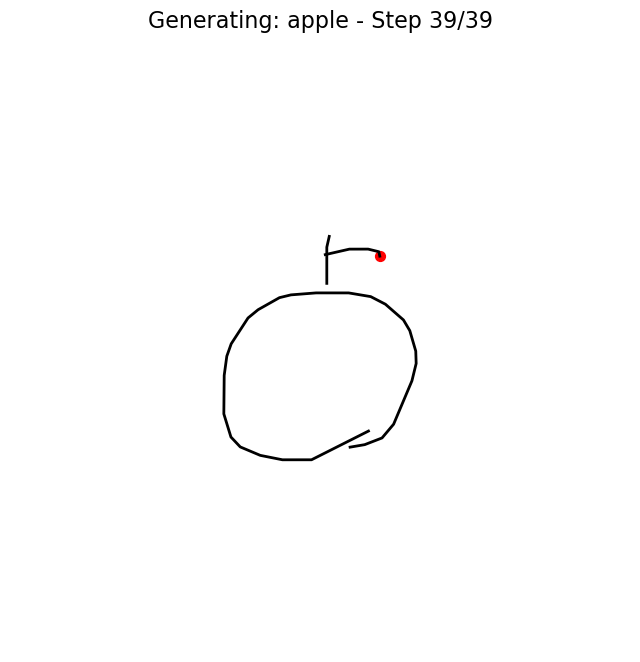

In [5]:
import numpy as np
import torch
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
from IPython.display import HTML
import os
plt.ion() 
# Load the trained model and required parameters
def load_model():
    # Load the saved model
    checkpoint = torch.load('sketch_transformer_final.pth', map_location='cpu')
    
    # Extract model parameters
    data_classes = checkpoint['data_classes']
    block_size = checkpoint['block_size']
    x_mean = checkpoint['x_mean'] 
    y_mean = checkpoint['y_mean']
    x_std = checkpoint['x_std']
    y_std = checkpoint['y_std']

    model = TransformerModel(num_classes=len(data_classes))
    model.load_state_dict(checkpoint['model_state_dict'])
    model.eval()
    
    return model, data_classes, x_mean, y_mean, x_std, y_std

# Create step-by-step sketch generation animation
def create_sketch_animation(model, class_name, data_classes, temperature=0.8):
    """Generate and visualize a sketch for the specified class"""
    device = next(model.parameters()).device
    
    # Get class index
    class_idx = data_classes.index(class_name)
    class_tensor = torch.tensor([class_idx], device=device)
    
    print(f"Generating sketch for: {class_name}")
    
    # Generate sketch
    with torch.no_grad():
        x = torch.zeros(1, 1, 3, device=device)
        x[0, 0, 2] = 1.0  # Start with pen down
        
        sketch = model.generate(
            x,
            class_idx=class_tensor,
            max_new_tokens=100,
            break_eos=True,
            tau=temperature
        )
    
    # Convert to absolute coordinates
    strokes = sketch[0].cpu().numpy()
    x_coords = np.cumsum(strokes[:, 0])
    y_coords = np.cumsum(strokes[:, 1])
    pen_states = strokes[:, 2]
    
    # Create the animation
    fig, ax = plt.subplots(figsize=(8, 8))
    
    # Set limits with a bit of padding
    pad = max(10, (max(x_coords) - min(x_coords)) * 0.15)
    ax.set_xlim(min(x_coords)-pad, max(x_coords)+pad)
    ax.set_ylim(min(-y_coords)-pad, max(-y_coords)+pad)
    ax.axis('off')
    ax.set_title(f"Generating: {class_name}", fontsize=16)
    
    # For drawing strokes separately based on pen state
    stroke_segments = []
    current_segment = []
    
    for i in range(len(strokes)):
        if pen_states[i] == 0:  # Pen down
            current_segment.append((x_coords[i], -y_coords[i]))
        elif len(current_segment) > 0:  # Pen up, finish segment
            stroke_segments.append(current_segment)
            current_segment = []
    
    if len(current_segment) > 0:
        stroke_segments.append(current_segment)
    
    # Initialize with empty plot
    lines = []
    for _ in range(len(stroke_segments)):
        line, = ax.plot([], [], 'k-', lw=2)
        lines.append(line)
    
    # Current drawing position
    point = ax.scatter([], [], color='red', s=50)
    
    def init():
        for line in lines:
            line.set_data([], [])
        point.set_offsets(np.empty((0, 2)))
        return lines + [point]
    
    def update(frame):
        # Clear previous drawing
        for line in lines:
            line.set_data([], [])
        
        # Draw strokes up to current frame
        points_drawn = 0
        current_x, current_y = 0, 0
        
        for i, segment in enumerate(stroke_segments):
            segment = np.array(segment)
            if points_drawn + len(segment) <= frame:
                # Draw the entire segment
                lines[i].set_data(segment[:, 0], segment[:, 1])
                points_drawn += len(segment)
                if len(segment) > 0:
                    current_x, current_y = segment[-1]
            elif points_drawn <= frame:
                # Draw part of this segment
                points_to_draw = frame - points_drawn + 1
                lines[i].set_data(segment[:points_to_draw, 0], segment[:points_to_draw, 1])
                if points_to_draw > 0:
                    current_x, current_y = segment[points_to_draw-1]
                break
            else:
                break
        
        # Update the current drawing position
        point.set_offsets([[current_x, current_y]])
        
        # Add progress indicator
        ax.set_title(f"Generating: {class_name} - Step {frame+1}/{len(x_coords)}", fontsize=16)
        
        return lines + [point]
    
    anim = FuncAnimation(fig, update, frames=len(x_coords),
                         init_func=init, blit=True, interval=50)
    
    return HTML(anim.to_jshtml())

# Compare generated sketches with real examples
def compare_sketches(model, class_name, data_classes, real_examples):
    """Compare generated sketches with real examples from the dataset"""
    device = next(model.parameters()).device
    
    # Get class index
    class_idx = data_classes.index(class_name)
    class_tensor = torch.tensor([class_idx], device=device)
    
    # Generate multiple sketches
    generated_sketches = []
    for _ in range(3):  # Generate 3 examples
        with torch.no_grad():
            x = torch.zeros(1, 1, 3, device=device)
            x[0, 0, 2] = 1.0
            sketch = model.generate(x, class_idx=class_tensor, max_new_tokens=100)
            generated_sketches.append(sketch[0].cpu().numpy())
    
    # Create comparison plot
    fig, axes = plt.subplots(2, 3, figsize=(15, 10))
    fig.suptitle(f"Comparison for class: {class_name}", fontsize=16)
    
    # Plot real examples
    for i in range(3):
        if i < len(real_examples):
            real_sketch = real_examples[i]
            real_x = np.cumsum(real_sketch[:, 0])
            real_y = np.cumsum(real_sketch[:, 1])
            axes[0, i].plot(real_x, -real_y, 'k-', lw=2)
            axes[0, i].set_title(f"Real Example {i+1}")
            axes[0, i].axis('off')
    
    # Plot generated examples
    for i in range(3):
        gen_sketch = generated_sketches[i]
        gen_x = np.cumsum(gen_sketch[:, 0])
        gen_y = np.cumsum(gen_sketch[:, 1])
        axes[1, i].plot(gen_x, -gen_y, 'k-', lw=2)
        axes[1, i].set_title(f"Generated Example {i+1}")
        axes[1, i].axis('off')
    
    plt.tight_layout()
    return fig

# Main function to run visualization
def run_visualization():
    # Load the model
    model, data_classes, _, _, _, _ = load_model()
    
    # Get available classes
    print(f"Available classes: {data_classes}")
    
    # Generate and animate sketch for a specific class
    class_name = input("Enter class name to visualize (e.g., 'cat'): ")
    if class_name not in data_classes:
        print(f"Class '{class_name}' not found. Using 'cat' instead.")
        class_name = "cat"
    
    # Create animation
    animation = create_sketch_animation(model, class_name, data_classes)
    return animation

# Run the visualization
animation = run_visualization()
animation


In [3]:
# First, load your saved model
checkpoint = torch.load('sketch_transformer_final.pth', map_location='cpu')

# Extract data classes from the checkpoint
data_classes = checkpoint['data_classes']

model = TransformerModel(num_classes=len(data_classes))

# Load the weights from the checkpoint
model.load_state_dict(checkpoint['model_state_dict'])
model.eval()


Model initialized with 11 classes and 62 max sequence length


/tmp/ipykernel_389182/4088864124.py:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load('sketch_transformer_final.pth', map_location='cpu')


TransformerModel(
  (stroke_embedding_proj): Linear(in_features=2, out_features=384, bias=False)
  (pen_embedding_table): Embedding(3, 384)
  (position_embedding_table): Embedding(62, 384)
  (class_embedding_table): Embedding(11, 384)
  (blocks): Sequential(
    (0): Block(
      (sa_heads): MultiHead(
        (heads): ModuleList(
          (0-5): 6 x Head(
            (query): Linear(in_features=384, out_features=64, bias=False)
            (key): Linear(in_features=384, out_features=64, bias=False)
            (value): Linear(in_features=384, out_features=64, bias=False)
          )
        )
        (proj): Linear(in_features=384, out_features=384, bias=True)
        (dropout): Dropout(p=0.2, inplace=False)
      )
      (ffwd): FeedForward(
        (net): Sequential(
          (0): Linear(in_features=384, out_features=1536, bias=True)
          (1): ReLU()
          (2): Linear(in_features=1536, out_features=384, bias=True)
          (3): Dropout(p=0.2, inplace=False)
        )
   

Generating apple...
Generating tree...
Generating fish...


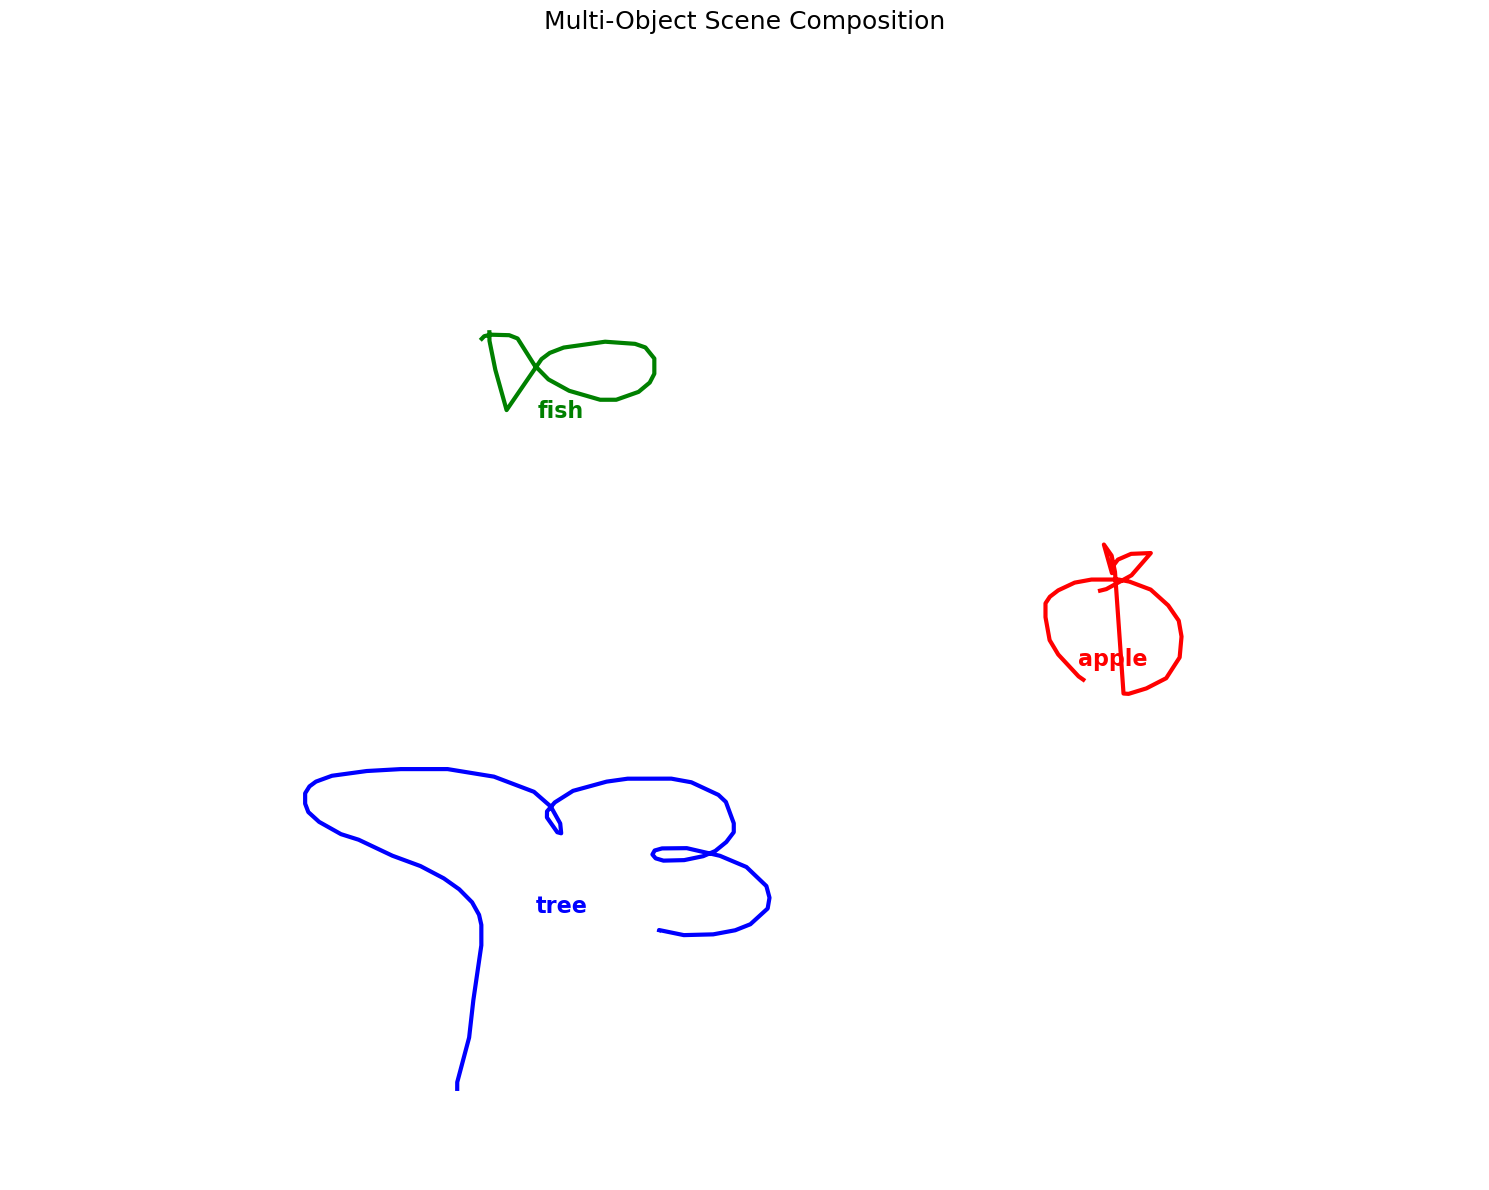

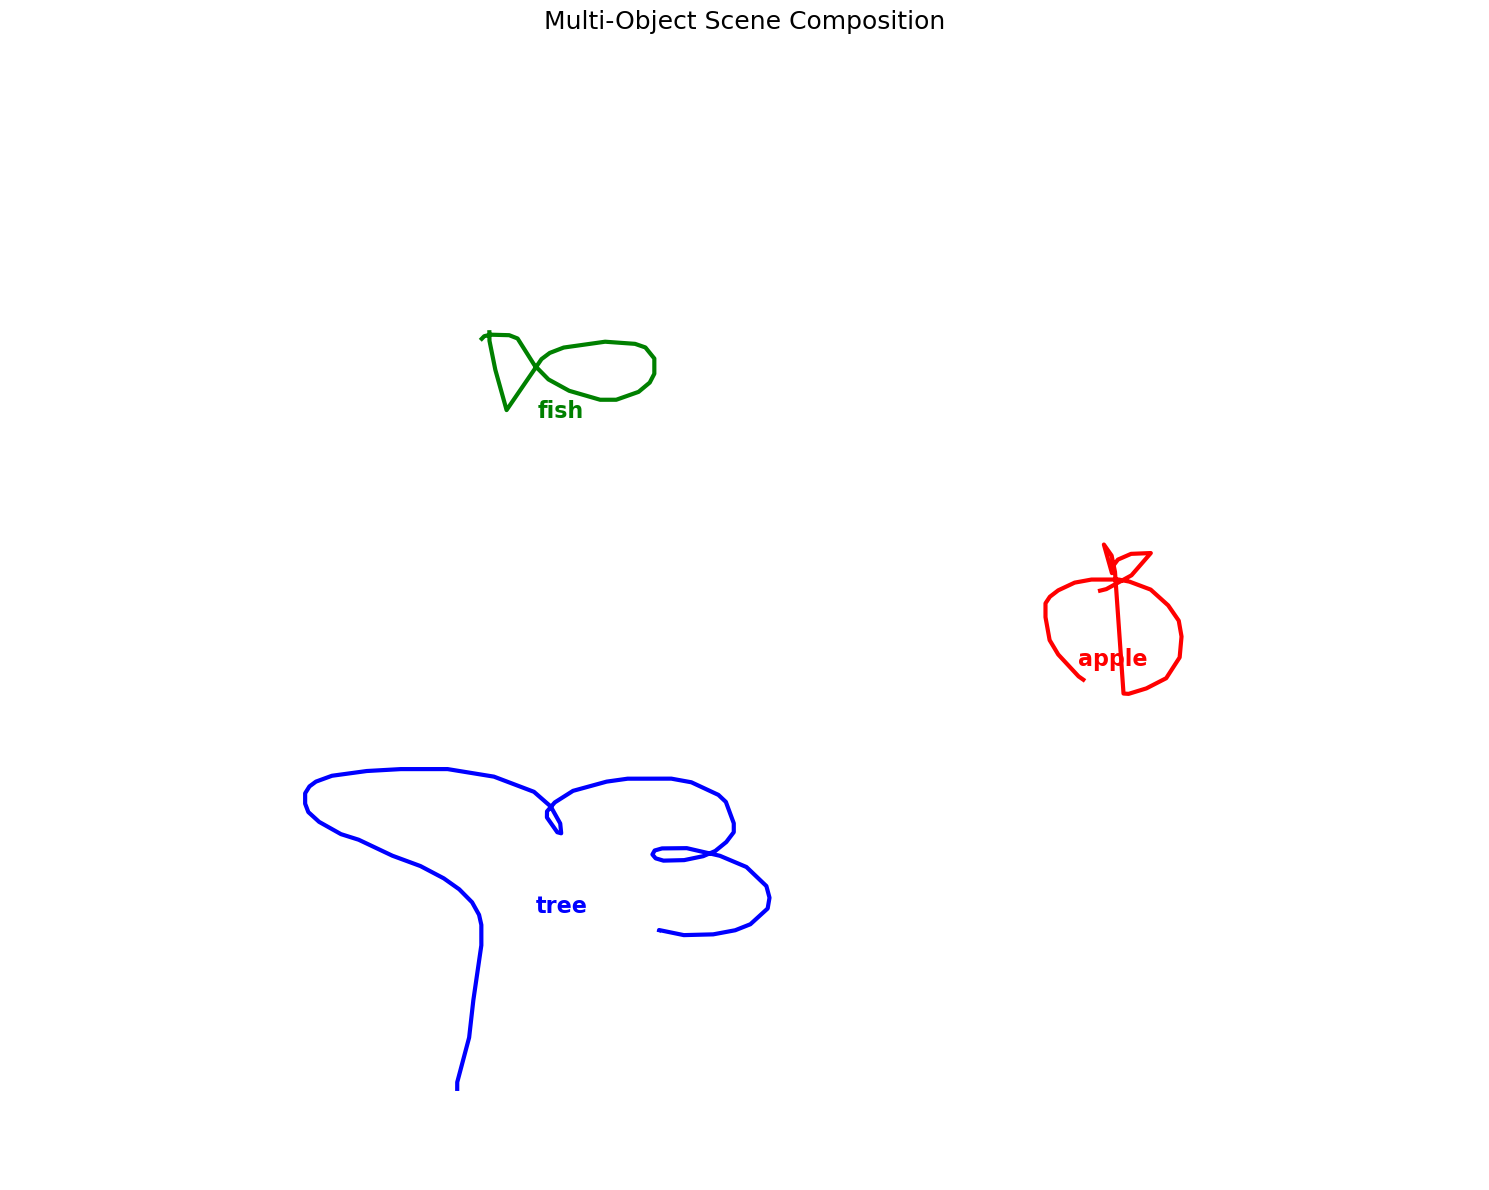

In [8]:
def generate_multi_object_scene(model, object_names, data_classes, scale_factor=9.0):
    """Generate a properly rendered scene with multiple objects at a larger scale"""
    device = next(model.parameters()).device
    
    # Create a larger figure for the complete scene
    fig, ax = plt.subplots(figsize=(15, 12) ) # Increased figure size
    ax.set_xlim(-300, 300)  # Expanded viewport
    ax.set_ylim(-300, 300)
    ax.axis('off')
    
    # Set different colors for different objects
    colors = ['red', 'blue', 'green', 'purple', 'orange']
    
    # Position objects in a wider circle
    positions = []
    circle_radius = 150  # Increased radius for more space
    for i in range(len(object_names)):
        angle = 2 * np.pi * i / len(object_names)
        x = circle_radius * np.cos(angle)
        y = circle_radius * np.sin(angle)
        positions.append((x, y))
    
    # Generate and draw each object
    for i, obj_name in enumerate(object_names):
        print(f"Generating {obj_name}...")
        
        # Get class index and generate sketch
        class_idx = data_classes.index(obj_name)
        class_tensor = torch.tensor([class_idx], device=device)
        
        with torch.no_grad():
            sketch = model.generate(
                torch.zeros(1, 1, 3, device=device),
                class_idx=class_tensor,
                max_new_tokens=80,
                break_eos=True,
                tau=0.65
            )
        
        # Calculate coordinates
        strokes = sketch[0].cpu().numpy()
        x_coords = np.cumsum(strokes[:, 0])
        y_coords = np.cumsum(strokes[:, 1])
        
        # Apply scaling to make sketches bigger
        x_coords = x_coords * scale_factor
        y_coords = y_coords * scale_factor
        
        # Center the sketch
        x_center = np.mean(x_coords)
        y_center = np.mean(y_coords)
        
        # Apply offset to position the sketch
        pos_x, pos_y = positions[i]
        x_offset = pos_x - x_center
        y_offset = pos_y - y_center
        
        # Draw the sketch with thicker lines
        ax.plot(x_coords + x_offset, -y_coords - y_offset, 
               color=colors[i % len(colors)], lw=3)  # Increased line width
        
        # Larger font for labels
        ax.text(pos_x, -pos_y - 30, obj_name,  # Moved text down a bit
               fontsize=16, ha='center', color=colors[i % len(colors)], weight='bold')
    
    plt.title("Multi-Object Scene Composition", fontsize=18)
    plt.tight_layout()
    plt.show()
    
    return fig

# Usage example:
objects = ["apple", "tree", "fish",]
generate_multi_object_scene(model, objects, data_classes)
